In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# Data aggregation

In [331]:
df_bike_trips = pd.read_parquet('../../data/bike_trips_cleaned.parquet')
df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,start_lon,end_lat,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip
index,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,-75.143749,39.969241,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,-75.149370,39.954694,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,-75.159952,39.945664,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,-75.162361,39.940735,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,-75.144145,39.938280,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0


In [332]:
# floor start and end times of trips to hour value, i.e. ignore minutes and seconds
df_bike_trips['start_time_floored'] = df_bike_trips['start_time'].dt.floor('H')
df_bike_trips['end_time_floored'] = df_bike_trips['end_time'].dt.floor('H')

df_bike_trips.head(70)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0,2016-01-01 00:00:00,2016-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2016-01-01 02:02:00,2016-01-01 02:16:00,3041,3041,3560,Walk-up,"Girard Station, MFL","Girard Station, MFL",0 days 00:14:00,39.969241,...,-75.136180,0.000000,0.000000,2016-01-01 02:09:00,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 02:00:00,2016-01-01 02:00:00
66,2016-01-01 01:58:00,2016-01-01 02:21:00,3052,3070,3555,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:23:00,39.947164,...,-75.140359,1.788087,4.664576,2016-01-01 02:09:30,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00
67,2016-01-01 01:59:00,2016-01-01 02:21:00,3052,3070,3440,Walk-up,"Spring Garden Station, MFL",9th & Locust,0 days 00:22:00,39.947164,...,-75.140359,1.788087,4.876602,2016-01-01 02:10:00,2016-01-01 02:00:00,6.7,6.7,0.0,2016-01-01 01:00:00,2016-01-01 02:00:00


In [333]:
# calculate the number of starting and ending trips for each hour
starting_trips_grouped = (
    df_bike_trips.groupby(["start_time_floored"])
    .size()
    .to_frame("starting_trips")
)
ending_trips_grouped = (
    df_bike_trips.groupby(["end_time_floored"])
    .size()
    .to_frame("ending_trips")
)

df_bike_trips.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,end_station_name,start_station_name,duration,start_lat,...,end_lon,distance,speed,average_time,date_time,max_temp,min_temp,precip,start_time_floored,end_time_floored
index,,,,,,,,,,,,,,,,,,,,,
0,2016-01-01 00:04:00,2016-01-01 00:14:00,3046,3041,3564,Indego30,"Girard Station, MFL",2nd & Market,0 days 00:10:00,39.949895,...,-75.136180,1.005648,6.033888,2016-01-01 00:09:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
1,2016-01-01 00:07:00,2016-01-01 00:29:00,3028,3019,2629,Indego30,6th & Race,4th & Bainbridge,0 days 00:22:00,39.940735,...,-75.149496,0.397798,1.084905,2016-01-01 00:18:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
2,2016-01-01 00:14:00,2016-01-01 00:27:00,3007,3066,3430,Indego30,19th & Lombard,"11th & Pine, Kahn Park",0 days 00:13:00,39.945123,...,-75.173272,1.480278,6.832050,2016-01-01 00:20:30,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
3,2016-01-01 00:20:00,2016-01-01 00:30:00,3045,3028,3715,Indego30,4th & Bainbridge,13th & Locust,0 days 00:10:00,39.947947,...,-75.149370,1.458133,8.748797,2016-01-01 00:25:00,2016-01-01 00:00:00,6.7,6.7,0.0,2016-01-01,2016-01-01
4,2016-01-01 00:20:00,2016-01-01 00:42:00,3005,3064,3351,Walk-up,"18th & Washington, Chew Playground","Welcome Park, NPS",0 days 00:22:00,39.947383,...,-75.173873,3.313616,9.037136,2016-01-01 00:31:00,2016-01-01 01:00:00,7.2,7.2,0.0,2016-01-01,2016-01-01


In [334]:
# combine these values into a single dataframe and determine whether data cleaning is necessary
df_bike_trips_hourly = pd.concat([starting_trips_grouped, ending_trips_grouped], axis=1)
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    54
ending_trips      43
dtype: int64

In [335]:
df_bike_trips_hourly = df_bike_trips_hourly.fillna(0) 
df_bike_trips_hourly.isna().sum()
#df_bike_trips_hourly.tail()

starting_trips    0
ending_trips      0
dtype: int64

In [336]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Feature engineering

In [337]:
df_bike_trips_hourly.head()


,starting_trips,ending_trips
2016-01-01 00:00:00,26.0,17.0
2016-01-01 01:00:00,39.0,32.0
2016-01-01 02:00:00,33.0,37.0
2016-01-01 03:00:00,6.0,10.0
2016-01-01 04:00:00,1.0,1.0


### Add weather features

In [338]:
df_weather = pd.read_parquet('../../data/weather_hourly_philadelphia_cleaned.parquet')
#df_weather.head()
print(len(df_weather))

8312


In [339]:
df_bike_trips_hourly['max_temp'] = df_weather['max_temp']
df_bike_trips_hourly['min_temp'] = df_weather['min_temp']
df_bike_trips_hourly['precip'] = df_weather['precip']
df_bike_trips_hourly.isna().sum()
print(len(df_bike_trips_hourly))
#df_bike_trips_hourly.head()

8588


In [340]:
#drop null values
df_bike_trips_hourly = df_bike_trips_hourly.dropna()
print(len(df_bike_trips_hourly))

8124


### Time related features

In [341]:
def get_season(dates):
    seasons = []
    for date in dates:
        # Extract the month and day from the datetime object
        month = date.month
        day = date.day

        # Define the start and end dates for each season
        spring_start = '03-20'
        spring_end = '06-20'
        summer_start = '06-21'
        summer_end = '09-22'
        fall_start = '09-23'
        fall_end = '12-20'

        # Check which season the input date belongs to
        if (month == 3 and day >= 20) or (month > 3 and month < 6) or (month == 6 and day <= 20):
            seasons.append('1') # Spring
        elif (month == 6 and day >= 21) or (month > 6 and month < 9) or (month == 9 and day <= 22):
            seasons.append('2') # Summer
        elif (month == 9 and day >= 23) or (month > 9 and month < 12) or (month == 12 and day <= 20):
            seasons.append('3') # Fall
        else:
            seasons.append('4') # Winter
    return seasons

In [342]:
#
df_bike_trips_hourly['hour'] = df_bike_trips_hourly.index.hour
df_bike_trips_hourly['day_of_week'] = df_bike_trips_hourly.index.day_of_week
df_bike_trips_hourly['month'] = df_bike_trips_hourly.index.month
df_bike_trips_hourly['day_of_year'] = df_bike_trips_hourly.index.day_of_year
df_bike_trips_hourly['week'] = df_bike_trips_hourly.index.isocalendar().week.astype('int64')
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['day_of_week'] < 5
#is_weekday as binary variable
df_bike_trips_hourly['is_weekday'] = df_bike_trips_hourly['is_weekday'].astype(int)
df_bike_trips_hourly['date'] = df_bike_trips_hourly.index.date.astype('datetime64[ns]')


df_bike_trips_hourly['season'] = get_season(df_bike_trips_hourly['date'])
df_bike_trips_hourly['season'] = df_bike_trips_hourly['season'].astype(int)
df_bike_trips_hourly.head()


,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season
2016-01-01 00:00:00,26.0,17.0,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4
2016-01-01 01:00:00,39.0,32.0,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4
2016-01-01 02:00:00,33.0,37.0,6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4
2016-01-01 03:00:00,6.0,10.0,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4
2016-01-01 04:00:00,1.0,1.0,6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4


In [343]:
df_bike_trips_hourly.iloc[1600:1650,:]

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season
2016-03-18 06:00:00,26.0,25.0,13.3,13.3,0.0,6,4,3,78,11,1,2016-03-18,4
2016-03-18 07:00:00,76.0,58.0,13.3,13.3,0.0,7,4,3,78,11,1,2016-03-18,4
2016-03-18 08:00:00,146.0,140.0,10.6,10.6,0.0,8,4,3,78,11,1,2016-03-18,4
2016-03-18 09:00:00,91.0,104.0,10.6,10.6,0.0,9,4,3,78,11,1,2016-03-18,4
2016-03-18 10:00:00,64.0,69.0,8.3,8.3,0.0,10,4,3,78,11,1,2016-03-18,4
2016-03-18 11:00:00,80.0,54.0,8.3,8.3,0.0,11,4,3,78,11,1,2016-03-18,4
2016-03-18 12:00:00,80.0,86.0,9.4,9.4,0.0,12,4,3,78,11,1,2016-03-18,4
2016-03-18 13:00:00,72.0,77.0,10.6,10.6,0.0,13,4,3,78,11,1,2016-03-18,4
2016-03-18 14:00:00,87.0,93.0,12.2,12.2,0.0,14,4,3,78,11,1,2016-03-18,4
2016-03-18 15:00:00,65.0,63.0,13.9,13.9,0.0,15,4,3,78,11,1,2016-03-18,4


In [344]:
df_bike_trips_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8124 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   starting_trips  8124 non-null   float64       
 1   ending_trips    8124 non-null   float64       
 2   max_temp        8124 non-null   float64       
 3   min_temp        8124 non-null   float64       
 4   precip          8124 non-null   float64       
 5   hour            8124 non-null   int64         
 6   day_of_week     8124 non-null   int64         
 7   month           8124 non-null   int64         
 8   day_of_year     8124 non-null   int64         
 9   week            8124 non-null   int64         
 10  is_weekday      8124 non-null   int64         
 11  date            8124 non-null   datetime64[ns]
 12  season          8124 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(7)
memory usage: 888.6 KB


## Holiday feature ## 

Holidays.json created by ChatGPT by openAI. ggf. Erweiterung für dynamische Feiertage nötig falls wir mehrere Jahre angucken wollen. ChatGPT nutzt nur Daten bis 2021, daher fehlt Juneteenth (neuer Feiertag in USA, in 2021 eingeführt), aber ist für uns soweit irrelevant, da wir eh nur Daten des Jahres 2016 nutzen.

In [345]:
holidays_file = open("../../data/holidays.json")
holidays_json = json.loads(holidays_file.read())

In [346]:
# Convert the dates to datetime objects
# holidays = {k: pd.to_datetime(v) for k, v in holidays.items()}

# Create a dataframe from the dictionary
holidays_df = pd.DataFrame.from_dict(holidays_json, orient='index', columns=['date']).reset_index()
holidays_df = holidays_df.rename(columns={'date': 'holiday_name'})
holidays_df = holidays_df.rename(columns={'index': 'date'})
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

holidays_df.head()





,date,holiday_name
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-15,Presidents' Day
3,2016-05-30,Memorial Day
4,2016-07-04,Independence Day


In [347]:
# df_bike_trips_hourly = df_bike_trips_hourly.merge(holidays_df, on='date', how='left')
df_bike_trips_hourly = df_bike_trips_hourly.reset_index().merge(holidays_df, on='date', how='left').set_index('index')
df_bike_trips_hourly.head(5)

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season,holiday_name
index,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 01:00:00,39.0,32.0,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 02:00:00,33.0,37.0,6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 03:00:00,6.0,10.0,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4,New Year's Day
2016-01-01 04:00:00,1.0,1.0,6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4,New Year's Day


In [348]:

df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['holiday_name'].notna()
df_bike_trips_hourly = df_bike_trips_hourly.drop(columns=['holiday_name'])
df_bike_trips_hourly['is_holiday'] = df_bike_trips_hourly['is_holiday'].astype(int)
df_bike_trips_hourly.columns

Index(['starting_trips', 'ending_trips', 'max_temp', 'min_temp', 'precip',
       'hour', 'day_of_week', 'month', 'day_of_year', 'week', 'is_weekday',
       'date', 'season', 'is_holiday'],
      dtype='object')

In [349]:
df_bike_trips_hourly.head(25)

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,date,season,is_holiday
index,,,,,,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,6.7,6.7,0.0,0,4,1,1,53,1,2016-01-01,4,1
2016-01-01 01:00:00,39.0,32.0,7.2,7.2,0.0,1,4,1,1,53,1,2016-01-01,4,1
2016-01-01 02:00:00,33.0,37.0,6.7,6.7,0.0,2,4,1,1,53,1,2016-01-01,4,1
2016-01-01 03:00:00,6.0,10.0,6.7,6.7,0.0,3,4,1,1,53,1,2016-01-01,4,1
2016-01-01 04:00:00,1.0,1.0,6.1,6.1,0.0,4,4,1,1,53,1,2016-01-01,4,1
2016-01-01 05:00:00,4.0,3.0,6.1,6.1,0.0,5,4,1,1,53,1,2016-01-01,4,1
2016-01-01 06:00:00,2.0,1.0,5.6,5.6,0.0,6,4,1,1,53,1,2016-01-01,4,1
2016-01-01 07:00:00,11.0,12.0,5.0,5.0,0.0,7,4,1,1,53,1,2016-01-01,4,1
2016-01-01 08:00:00,11.0,8.0,5.0,5.0,0.0,8,4,1,1,53,1,2016-01-01,4,1


In [350]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Correlation

In [351]:
df_bike_trips_hourly.corr()

/var/folders/4p/_hw5n9y10lxbcmghgwqb7n7m0000gn/T/ipykernel_60388/847747354.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_bike_trips_hourly.corr()


,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,season,is_holiday
starting_trips,1.000000,0.986824,0.367385,0.367965,-0.112003,0.339070,-0.086754,0.225140,0.221598,0.202131,0.112407,-0.199497,-0.042340
ending_trips,0.986824,1.000000,0.383563,0.384222,-0.116387,0.365555,-0.086422,0.227017,0.223475,0.203810,0.111463,-0.201071,-0.042724
max_temp,0.367385,0.383563,1.000000,0.999684,-0.072206,0.147838,-0.006414,0.211212,0.212795,0.179991,0.016651,-0.542297,-0.072361
min_temp,0.367965,0.384222,0.999684,1.000000,-0.079202,0.146652,-0.006564,0.211436,0.213032,0.180394,0.016850,-0.542557,-0.072115
precip,-0.112003,-0.116387,-0.072206,-0.079202,1.000000,0.013636,-0.009228,-0.051463,-0.052260,-0.060522,-0.002292,0.017371,0.005585
hour,0.339070,0.365555,0.147838,0.146652,0.013636,1.000000,-0.003396,-0.014466,-0.014305,-0.013921,0.002290,0.008032,0.000495
day_of_week,-0.086754,-0.086422,-0.006414,-0.006564,-0.009228,-0.003396,1.000000,-0.008580,-0.008388,0.002763,-0.787167,0.019270,-0.109122
month,0.225140,0.227017,0.211212,0.211436,-0.051463,-0.014466,-0.008580,1.000000,0.996513,0.946965,0.004658,-0.018119,0.019396
day_of_year,0.221598,0.223475,0.212795,0.213032,-0.052260,-0.014305,-0.008388,0.996513,1.000000,0.946826,0.004154,-0.018615,0.016801
week,0.202131,0.203810,0.179991,0.180394,-0.060522,-0.013921,0.002763,0.946965,0.946826,1.000000,-0.005945,0.023521,0.077064


/var/folders/4p/_hw5n9y10lxbcmghgwqb7n7m0000gn/T/ipykernel_60388/844513621.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_bike_trips_hourly.corr()


<AxesSubplot:>

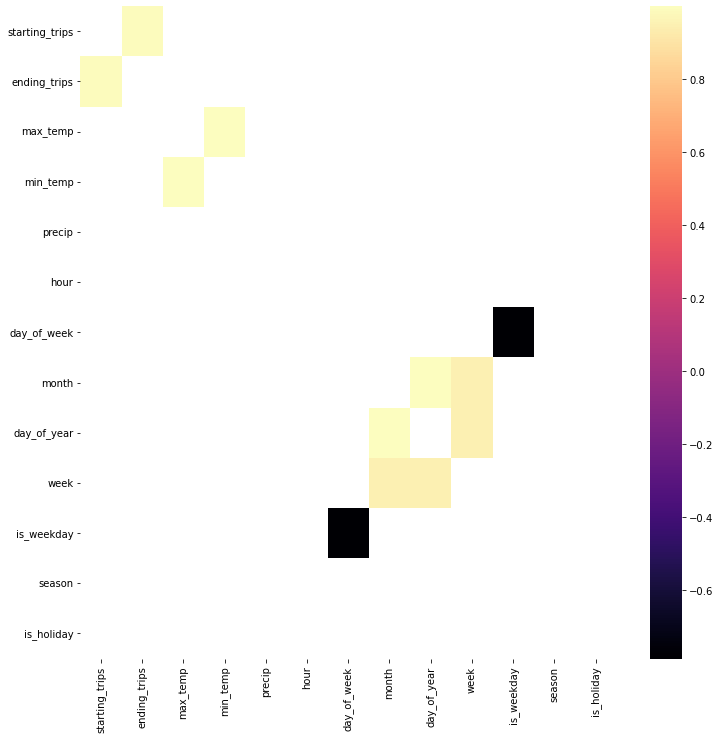

In [352]:
corr = df_bike_trips_hourly.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,12))
sns.heatmap(kot, cmap="magma")

In [353]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_hourly, .7)

/var/folders/4p/_hw5n9y10lxbcmghgwqb7n7m0000gn/T/ipykernel_60388/2233090415.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  xCorr = x.corr()


day_of_week     is_weekday       -0.787167
day_of_year     week              0.946826
month           week              0.946965
starting_trips  ending_trips      0.986824
month           day_of_year       0.996513
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

### Correlation with only numeric values in df - use this version as numeric_only will be deprecated

In [354]:
#drop all the columns that are not numeric columns (The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.)
columns_to_drop_corr = ['date']
df_bike_trips_corr = df_bike_trips_hourly.copy()
#df_bike_trips_corr.head()
#df_bike_trips_hourly.head()
df_bike_trips_corr.drop(columns_to_drop_corr, axis=1, inplace=True)

In [355]:
df_bike_trips_corr.corr()

,starting_trips,ending_trips,max_temp,min_temp,precip,hour,day_of_week,month,day_of_year,week,is_weekday,season,is_holiday
starting_trips,1.000000,0.986824,0.367385,0.367965,-0.112003,0.339070,-0.086754,0.225140,0.221598,0.202131,0.112407,-0.199497,-0.042340
ending_trips,0.986824,1.000000,0.383563,0.384222,-0.116387,0.365555,-0.086422,0.227017,0.223475,0.203810,0.111463,-0.201071,-0.042724
max_temp,0.367385,0.383563,1.000000,0.999684,-0.072206,0.147838,-0.006414,0.211212,0.212795,0.179991,0.016651,-0.542297,-0.072361
min_temp,0.367965,0.384222,0.999684,1.000000,-0.079202,0.146652,-0.006564,0.211436,0.213032,0.180394,0.016850,-0.542557,-0.072115
precip,-0.112003,-0.116387,-0.072206,-0.079202,1.000000,0.013636,-0.009228,-0.051463,-0.052260,-0.060522,-0.002292,0.017371,0.005585
hour,0.339070,0.365555,0.147838,0.146652,0.013636,1.000000,-0.003396,-0.014466,-0.014305,-0.013921,0.002290,0.008032,0.000495
day_of_week,-0.086754,-0.086422,-0.006414,-0.006564,-0.009228,-0.003396,1.000000,-0.008580,-0.008388,0.002763,-0.787167,0.019270,-0.109122
month,0.225140,0.227017,0.211212,0.211436,-0.051463,-0.014466,-0.008580,1.000000,0.996513,0.946965,0.004658,-0.018119,0.019396
day_of_year,0.221598,0.223475,0.212795,0.213032,-0.052260,-0.014305,-0.008388,0.996513,1.000000,0.946826,0.004154,-0.018615,0.016801
week,0.202131,0.203810,0.179991,0.180394,-0.060522,-0.013921,0.002763,0.946965,0.946826,1.000000,-0.005945,0.023521,0.077064


<AxesSubplot:>

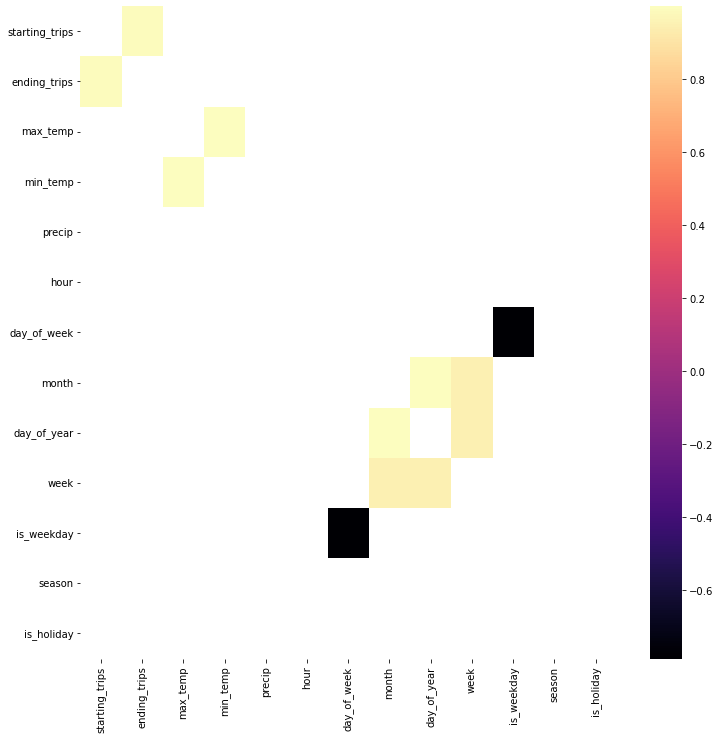

In [356]:
corr = df_bike_trips_corr.corr()

#kot = corr[((corr>=.7) or (corr<=-.7))]
kot = corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000)]
plt.figure(figsize=(12,12))
sns.heatmap(kot, cmap="magma")

In [357]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(df_bike_trips_corr, .7)

day_of_week     is_weekday       -0.787167
day_of_year     week              0.946826
month           week              0.946965
starting_trips  ending_trips      0.986824
month           day_of_year       0.996513
max_temp        min_temp          0.999684
starting_trips  starting_trips         NaN
dtype: float64

In [358]:
df_bike_trips_hourly.isna().sum()

starting_trips    0
ending_trips      0
max_temp          0
min_temp          0
precip            0
hour              0
day_of_week       0
month             0
day_of_year       0
week              0
is_weekday        0
date              0
season            0
is_holiday        0
dtype: int64

For starting trips the correlation can be ignored, as the correlation with itself is 1 and as there are no null values in our dataset. 

# Drop features

Looking at the *Correlation* seven pairs have high correlation. So either one of them can be dropped. The features that we will drop are: day_of_week, max_temp. For three pairs we see different correlation "relationships": day_of_year, as well as month correlate highly to week and month also correlates highly to day_of_year. So the one feature that we will keep is the month, as we also looked at it in our descriptive analytics. The starting_trips can be ignored in this case, as the correlation with the variable itself is always 1. We also drop 'date', because it's equivalent to day_of_year and it is already represented by the index.

In [359]:
columns_to_drop = ['max_temp', 'day_of_week', 'day_of_year', 'week', 'date']
df_bike_trips_hourly.drop(columns_to_drop, axis=1, inplace=True)
df_bike_trips_hourly.head()

,starting_trips,ending_trips,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,,
2016-01-01 00:00:00,26.0,17.0,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,39.0,32.0,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,33.0,37.0,6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,6.0,10.0,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,1.0,6.1,0.0,4,1,1,4,1


In [360]:
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly.parquet')

# Lasso regression

In [361]:
input_features = df_bike_trips_hourly.drop(columns=["starting_trips"])
predicted_variable = df_bike_trips_hourly["starting_trips"]

In [362]:
# scale input features
scaler = StandardScaler()
input_features_scaled = scaler.fit_transform(input_features.values)

In [363]:
input_features.head()

,ending_trips,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,
2016-01-01 00:00:00,17.0,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,32.0,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,37.0,6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,10.0,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,6.1,0.0,4,1,1,4,1


In [364]:
# fit data to the linear regression model
model = Lasso(alpha=1)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [72.33166417 -0.          0.         -0.2796798   0.          0.
 -0.         -0.        ]


## Lasso with optimal alpha

### K-fold cross validation

In [365]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(input_features_scaled, predicted_variable)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [366]:
model.alpha_

0.2236327309467648

### Best model

In [367]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(input_features_scaled, predicted_variable)

Lasso(alpha=0.2236327309467648)

In [368]:
print(list(zip(lasso_best.coef_, input_features)))

[(73.78715502068071, 'ending_trips'), (-0.6466065985568271, 'min_temp'), (0.023341455299180115, 'precip'), (-1.49291912631368, 'hour'), (0.0, 'month'), (0.0, 'is_weekday'), (-0.08328966368648394, 'season'), (-0.0, 'is_holiday')]


### Model evaluation

In [369]:
print('R squared training set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))
print('R squared test set', round(lasso_best.score(input_features_scaled, predicted_variable)*100, 2))


R squared training set 97.45
R squared test set 97.45


In [370]:
mean_squared_error(predicted_variable, lasso_best.predict(input_features_scaled))

140.58296858093482

## Lasso regression with best alpha

In [371]:
input_features.head()

,ending_trips,min_temp,precip,hour,month,is_weekday,season,is_holiday
index,,,,,,,,
2016-01-01 00:00:00,17.0,6.7,0.0,0,1,1,4,1
2016-01-01 01:00:00,32.0,7.2,0.0,1,1,1,4,1
2016-01-01 02:00:00,37.0,6.7,0.0,2,1,1,4,1
2016-01-01 03:00:00,10.0,6.7,0.0,3,1,1,4,1
2016-01-01 04:00:00,1.0,6.1,0.0,4,1,1,4,1


In [372]:
model = Lasso(alpha=0.2236327309467648)
model.fit(input_features_scaled, predicted_variable)
print("Coefficients ", model.coef_)


Coefficients  [ 7.37871550e+01 -6.46606599e-01  2.33414553e-02 -1.49291913e+00
  0.00000000e+00  0.00000000e+00 -8.32896637e-02 -0.00000000e+00]


# TODO: Begründung warum wir min_temp o.ä trotzdem im model behalten wollen und nicht droppen? 
# TODO: WEITER FEATURES FINDEN, 2 SIND ZU MAGER?
In general, it is a good idea to consider dropping features that are identified as unimportant by both lasso regression and feature correlation. However, you should also consider the context of your problem and the goals of your model. It is possible that some features that are identified as unimportant by these techniques may still be useful for your model, or that removing them may have unintended consequences. Therefore, it is important to carefully evaluate the impact of removing features on the performance of your model before making a final decision.

VIELLEICHT KANN DIESE BEGRÜNDUNG UNS HELFEN?

In [373]:
# trips_hourly_df = trips_hourly_df.drop(columns={"precip", "day_of_week"})
df_bike_trips_hourly.to_parquet('../../data/bike_trips_hourly_FINAL.parquet')